***Import necessary packages.***
While testing dask_process() class, make sure to call on functions from that class, not the regular process() class.

In [1]:
import pyUSID as usid
from pyUSID.processing.comp_utils import parallel_compute, get_MPI, group_ranks_by_socket, get_available_memory
from dask.distributed import Client
import dask.array as da

In [2]:
import os
os.listdir()

['dask_process.py',
 '.DS_Store',
 'Signal_Filter_GIV_expected.py',
 'pzt_nanocap_6_just_translation_copy.h5',
 '__pycache__',
 'gmode_utils.py',
 'Signal_Filter_GIV_expected.ipynb',
 '.ipynb_checkpoints',
 'Signal_Filter_GIV_expected.html',
 'fft.py',
 'foo.h5',
 'dask_signal_filter.py',
 'dask-worker-space']

In [3]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from shutil import copyfile
import tempfile

# I am importing pycroscopy from the original package but you will have to change yours
import sys
#sys.path.append('/Users/syz/PycharmProjects/pyUSID/')
sys.path.append('/Users/syz/PycharmProjects/pycroscopy/')
#from pycroscopy.processing import SignalFilter
#from pycroscopy.processing import fft
# You will need to do something like:
from fft import LowPassFilter
from dask_signal_filter import SignalFilter

***Creates temporary file*** as to not mess up original file.

In [4]:
orig_path = 'pzt_nanocap_6_just_translation_copy.h5'

with tempfile.TemporaryDirectory() as tmp_dir:
    h5_path = tmp_dir + 'gline.h5'
    copyfile(orig_path, h5_path)

***Finds and assigns main dataset, Raw_Data, to h5_main***

In [5]:
h5_f = h5py.File(h5_path, mode='r+')
# Not necessary I think but Chris used it
h5_f.atomic = True # This doesn't seem to make any difference

h5_grp = h5_f['Measurement_000/Channel_000']
h5_main = h5_grp['Raw_Data']
#h5_main.value
#h5_main = usid.USIDataset(h5_main)

In [20]:
sig_filt._read_data_chunk()
print(sig_filt.data)

dask.array<array, shape=(256, 133000), dtype=float16, chunksize=(1, 133000)>


In [7]:
samp_rate = h5_grp.attrs['IO_samp_rate_[Hz]']
num_spectral_pts = h5_main.shape[1]

frequency_filters = [LowPassFilter(num_spectral_pts, samp_rate, 10E+3)]
noise_tol = 1E-6

sig_filt = SignalFilter(h5_main, frequency_filters=frequency_filters,
                           noise_threshold=noise_tol, write_filtered=True,
                           write_condensed=False, num_pix=1, 
                        verbose=True)

# Set verbose=True to get more information on your print statements

Consider calling test() to check results before calling compute() which computes on the entire dataset and writes back to the HDF5 file
Checking for duplicates:


***Calls compute function.***

In [23]:
y

dask.array<array, shape=(256, 133000), dtype=float16, chunksize=(1, 133000)>

In [28]:
client = Client(processes=False)
def _unit_compute(chunk):
    chunk = np.fft.fftshift(np.fft.fft(chunk, axis=1), axes=1)
    return chunk
    
y = da.from_array(sig_filt.h5_main, chunks= (1, 133000))
results =  y.map_blocks(sig_filt._unit_computation, dtype= y.dtype)
array = results.compute()
array

TypeError: can't pickle _thread._local objects

In [9]:
h5_filt_grp = sig_filt.compute(override=True)

Creating HDF5 group and datasets to hold results
Rank 0 - Finished creating the Composite_Filter dataset
Rank 0 - Reusing source datasets position datasets
h5 group and file OK
quantity, units, main_data_name all OK
Selected empty dataset creation. OK so far
Provided h5 position indices and values OK
Passed all pre-tests for creating spectroscopic datasets
Indices:
[[0]]
Values:
[[1.]]
Starting to write Region References to Dataset /Measurement_000/Channel_000/Raw_Data-FFT_Filtering_000/Noise_Spec_Indices of shape: (1, 1)
About to write region reference: arb : (slice(0, 1, None), slice(None, None, None))
Comparing (slice(0, 1, None), slice(None, None, None)) with h5 dataset maxshape of (1, 1)
Region reference tuple now: [slice(0, 1, None), slice(None, None, None)]
Wrote Region Reference:arb
Writing header attributes: labels
Wrote Region References of Dataset Noise_Spec_Indices
Starting to write Region References to Dataset /Measurement_000/Channel_000/Raw_Data-FFT_Filtering_000/Noise_S

/anaconda3/lib/python3.6/site-packages/distributed/bokeh/core.py:74: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)
distributed.worker - WARNING -  Compute Failed
Function:  subgraph_callable
args:      (array([[-0.01525, -0.0868 ,  0.01912, ...,  1.732  ,  1.784  ,  1.851  ]],
      dtype=float16))
kwargs:    {}
Exception: AttributeError("'numpy.ndarray' object has no attribute 'chunks'",)

distributed.worker - WARNING -  Compute Failed
Function:  subgraph_callable
args:      (array([[-0.04773, -0.06714,  0.0685 , ...,  1.788  ,  1.871  ,  1.812  ]],
      dtype=float16))
kwargs:    {}
Exception: AttributeError("'numpy.ndarray' object has no attribute 'chunks'",)

distributed.worker - WARNING -  Compute Failed
Function:  subgraph_callable
args:      (array([[ 0.02037, -0.1396 ,  0.04535, ...,  1.739  ,  1.816  ,  1.839  ]],
      dtype=float16))
kwargs:    {

AttributeError: 'numpy.ndarray' object has no attribute 'chunks'

***Preparing for visualization.***

In [24]:
bias_vec = 6 * np.sin( np.linspace(0, 2*np.pi, 500))
#h5_filt = h5_filt_grp['Filtered_Data']
row_ind = 40
filt_row = array[row_ind].reshape(-1, bias_vec.size)
raw_row = h5_main[row_ind].reshape(-1, bias_vec.size)

***Visualization.***

/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


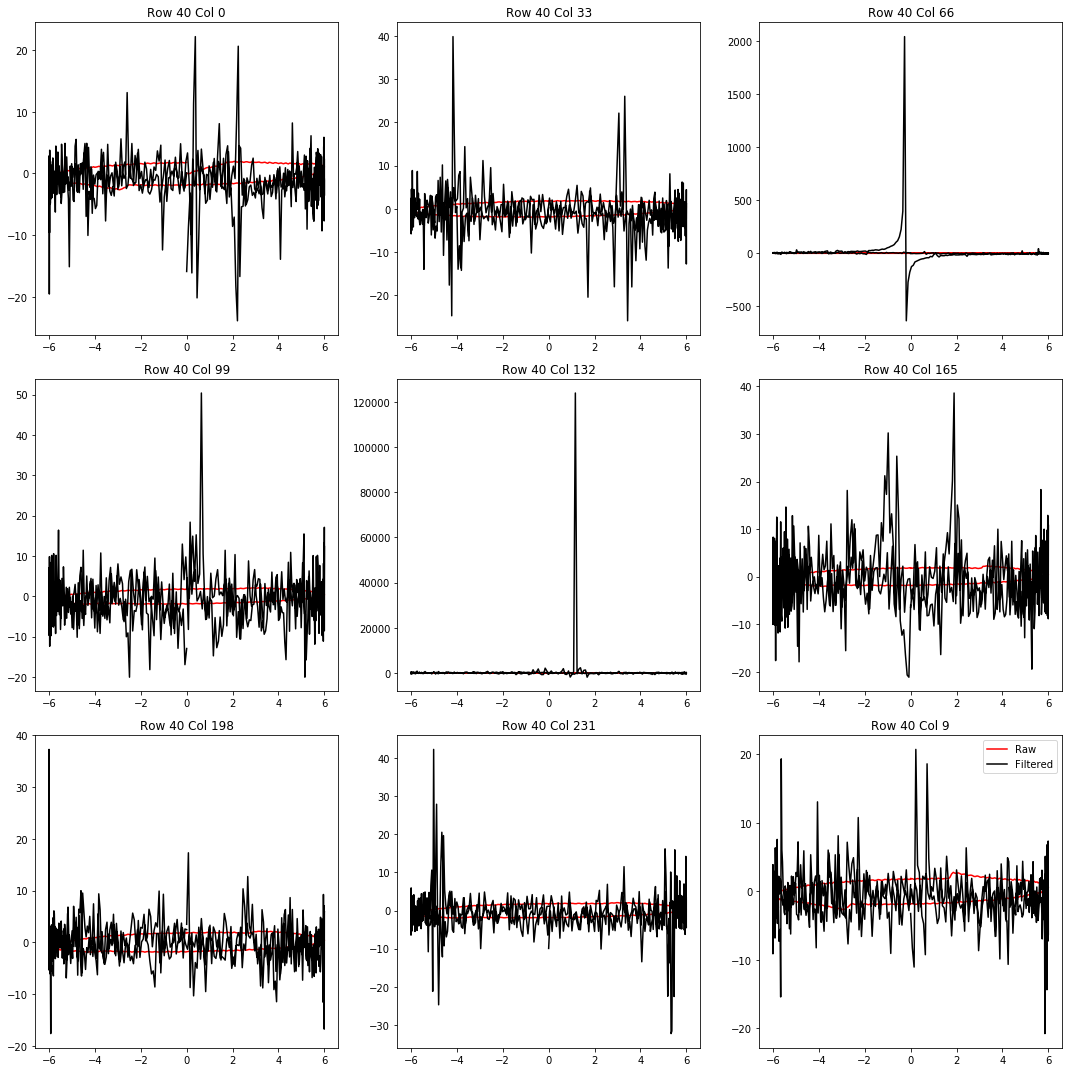

In [25]:
plots_on_side = 3

fig, axes = plt.subplots(nrows=plots_on_side, ncols=plots_on_side, figsize=(15, 15))
for axis, col_ind in zip(axes.flat, np.linspace(0, filt_row.shape[0]-1, plots_on_side ** 2, dtype=np.uint8)):
    axis.plot(bias_vec, raw_row[col_ind], 'r')
    axis.plot(bias_vec, filt_row[col_ind], 'k')
    axis.set_title('Row {} Col {}'.format(row_ind, col_ind))
axis.legend(['Raw', 'Filtered'])
fig.tight_layout()

In [ ]:
h5_f.close()